In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (4.0, 2.)
pylab.rcParams['lines.linewidth'] = 1.0
pylab.rcParams['font.size'] = 12.0
pylab.rcParams['axes.linewidth'] = 1
pylab.rcParams['axes.titlesize'] = '14' 
pylab.rcParams['axes.labelsize'] = '10'
pylab.rcParams['axes.linewidth'] = 1
pylab.rcParams['figure.subplot.wspace'] = 0.5

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm
from sklearn import mixture
from sklearn.cluster import MeanShift
from sklearn.decomposition import PCA
import itertools
from scipy import linalg
import matplotlib as mpl
import h5py

from detect import detectData
from localisation import localisation, amps, filteredSpikes

Populating the interactive namespace from numpy and matplotlib


In [2]:
import socket
if socket.gethostname() == 'dialga':
    data_path = '../rawDataSampleLarge.h5'
else:
    data_path = '/Users/josh/Project/data/rawDataSampleLarge.h5'
data = h5py.File(data_path, 'r')


In [3]:
# detectData(d, rawfilename, sfd, nDumpFrames, thres, maa = None, maxsl = None, minsl = None, ahpthr = None):

# MinAvgAmp minimal avg. amplitude of peak (in units of Qd)
# MaxSl dead time in frames after peak, used for further testing
# MinSl length considered for determining avg. spike amplitude
# AHPthr signal should go below that threshold within MaxSl-Slmin frames
# def detectData(data, spikefilename, shapefilename, sfd, thres, maa = None, maxsl = None, minsl = None, ahpthr = None):

# Matthias was using threshold 8
detectData(data_path, 'spikes', 'shapes', 30000, 20, maa=0, maxsl=12, minsl=3, ahpthr=0)
# detectData(data_path, 'spikes', 'shapes', 30000, 8)

(385, 1800000)
# Sampling rate: 30000
# Number of recorded channels: 385
# Analysing frames: 50100, Seconds:1
tInc:50069
Analysing 50069 frames; -22 50078
t0 = 0, t1 = 50069
(385, 50078)
Analysing 22 frames; 50047 50100
t0 = 50069, t1 = 50091
((385, 53), 20405)
Time taken for detection: 0:00:11.557954
Time per frame: 0:00:00.230697
Time per sample: 0:00:00.000599


(341288, 3)


<IPython.core.display.Javascript object>


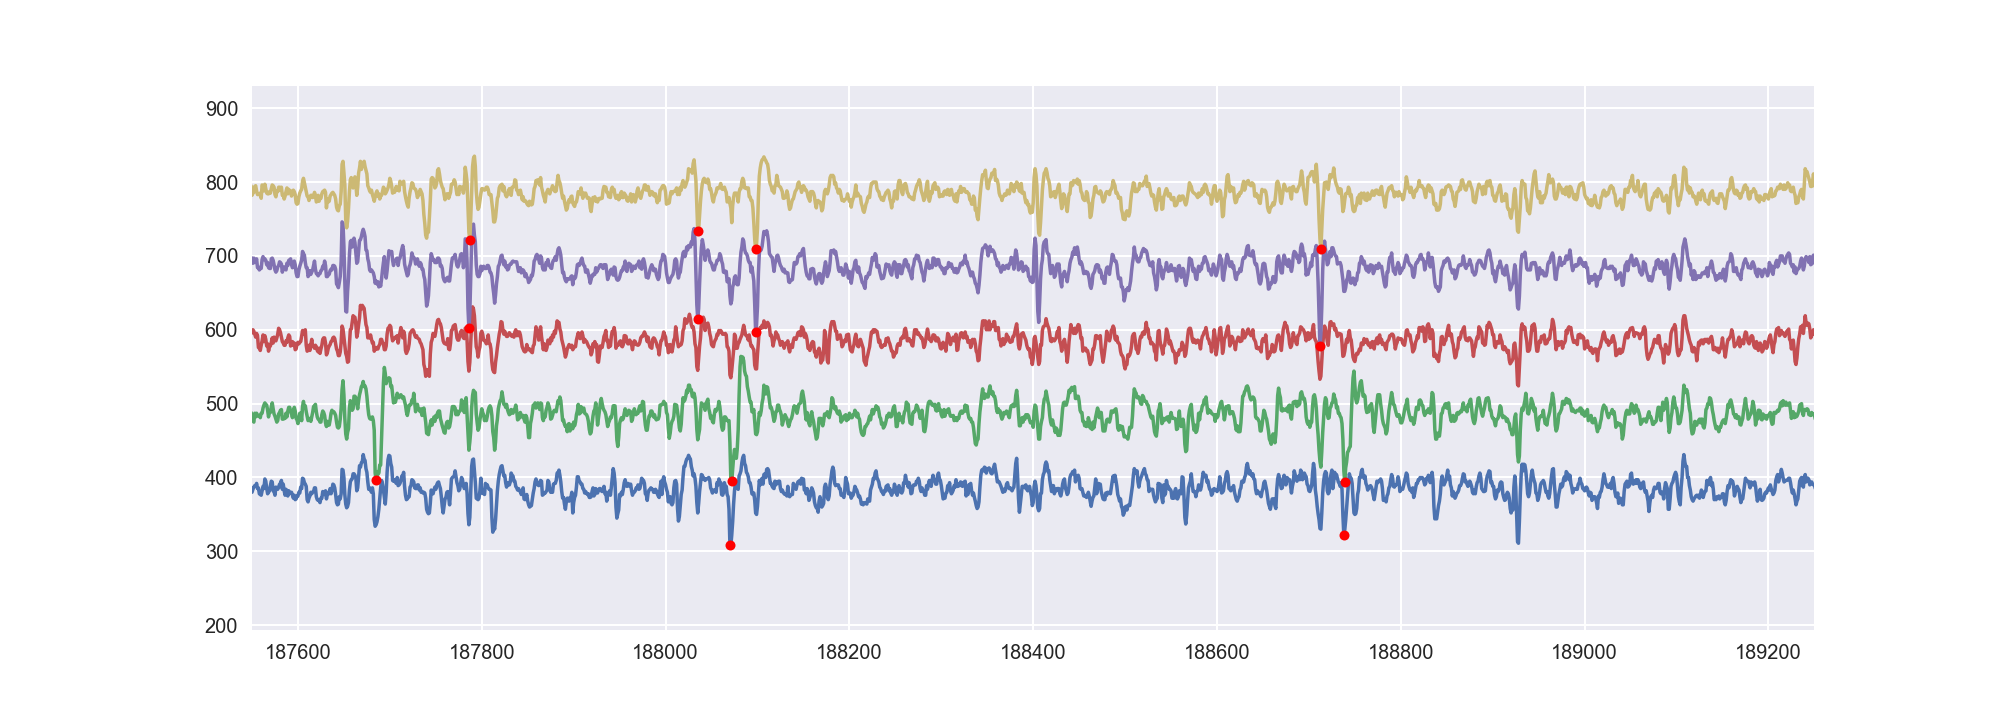

(187550, 189250)

In [4]:
%matplotlib notebook
sp = np.loadtxt('spikes')
print(sp.shape)
plt.figure(figsize=(14,5))
for i, channel in enumerate(range(0,5)):
    d = data['Raw'][channel,:]
    plt.plot(d+i*100)
    inds = np.where(sp[:,0]==channel)[0]
    plt.plot(sp[inds,1], d[sp[inds,1].astype(int)]+i*100,'r.',ms=10)
plt.xlim((187550,189250))

In [5]:
# plot individual shapes, remove baseline (now stored in shape file at position 4)

<IPython.core.display.Javascript object>


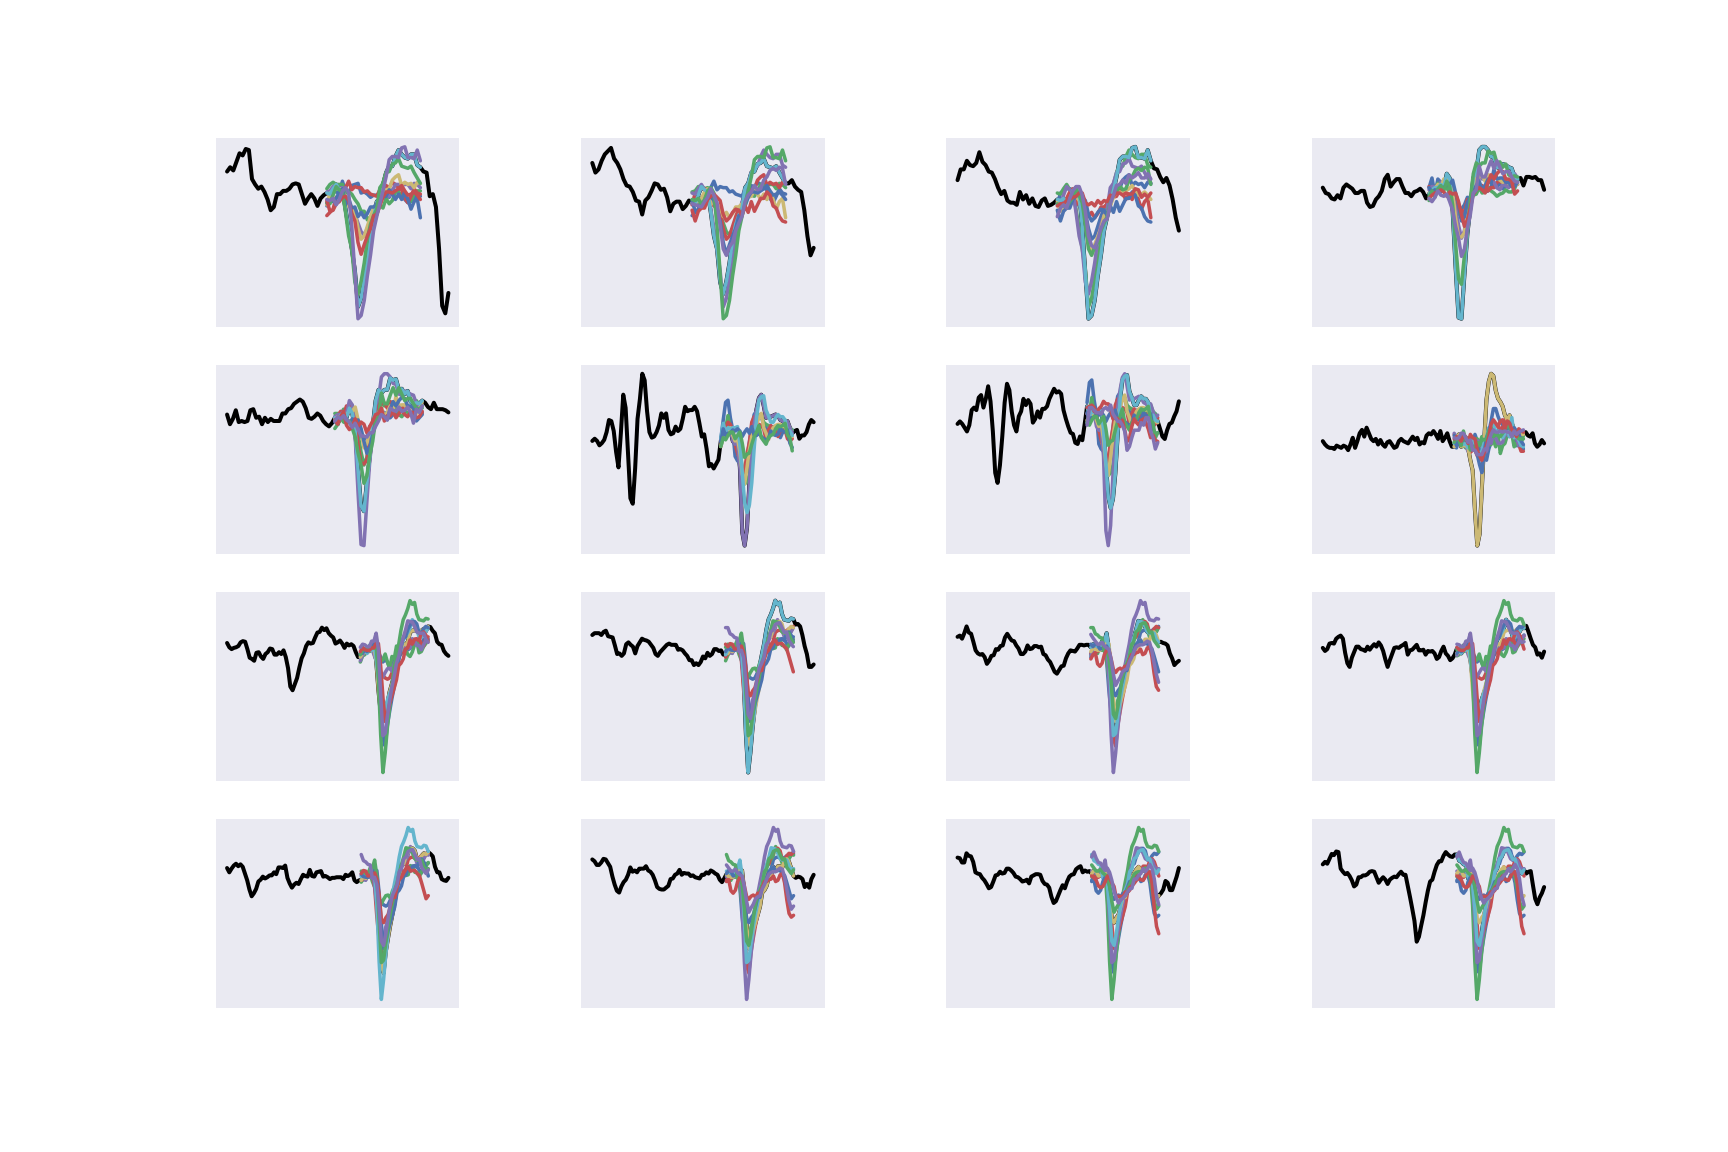

(333, 42, 1016, 32, 383)
(335, 42, 842, 32, 383)
(337, 42, 1141, 32, 383)
(93, 46, 1210, 32, 383)
(95, 47, 848, 32, 383)
(3, 64, 958, 25, 382)
(5, 65, 669, 32, 382)
(142, 67, 926, 32, 382)
(326, 69, 1053, 32, 382)
(329, 69, 1962, 32, 382)
(331, 69, 1346, 32, 382)
(327, 70, 890, 32, 382)
(328, 70, 1530, 32, 382)
(330, 70, 1114, 32, 382)
(332, 70, 689, 32, 382)
(333, 70, 1059, 32, 382)


In [5]:
plt.figure(figsize=(12,8))
f = open('shapes')
for i in range(16):
    plt.subplot(4,4,i+1)
    l = f.readline()
    line = l.split()
    ch = int(line[0])
    frame = int(line[1])
    amp = int(line[2])
    b = int(line[3])
    cutout = np.array(line[4:], dtype=int)
    d = data['Raw'][ch,:]
    plt.plot(d[:frame+30]-b, 'k', lw=2)
    for i in range(int(len(cutout)/32)):
        plt.plot(np.arange(frame-10, frame+21), cutout[i*32+1:(i+1)*32]-b, label=cutout[i*32])
#     plt.legend()
    plt.xticks(())
    plt.yticks(())
    print(ch, frame, amp, len(cutout)/10, b)
f.close()

In [2]:
filteredSpikes('shapes')

('Number of filtered spikes =', 148756)


In [2]:
localisation('filtered_shapes','chpos.npy', medians = True, clen = 32)

('count2 =', 261)
('empty string =', 0)


In [3]:
ls = np.loadtxt('local_spikes')
ls.shape

(148756, 2)

<IPython.core.display.Javascript object>


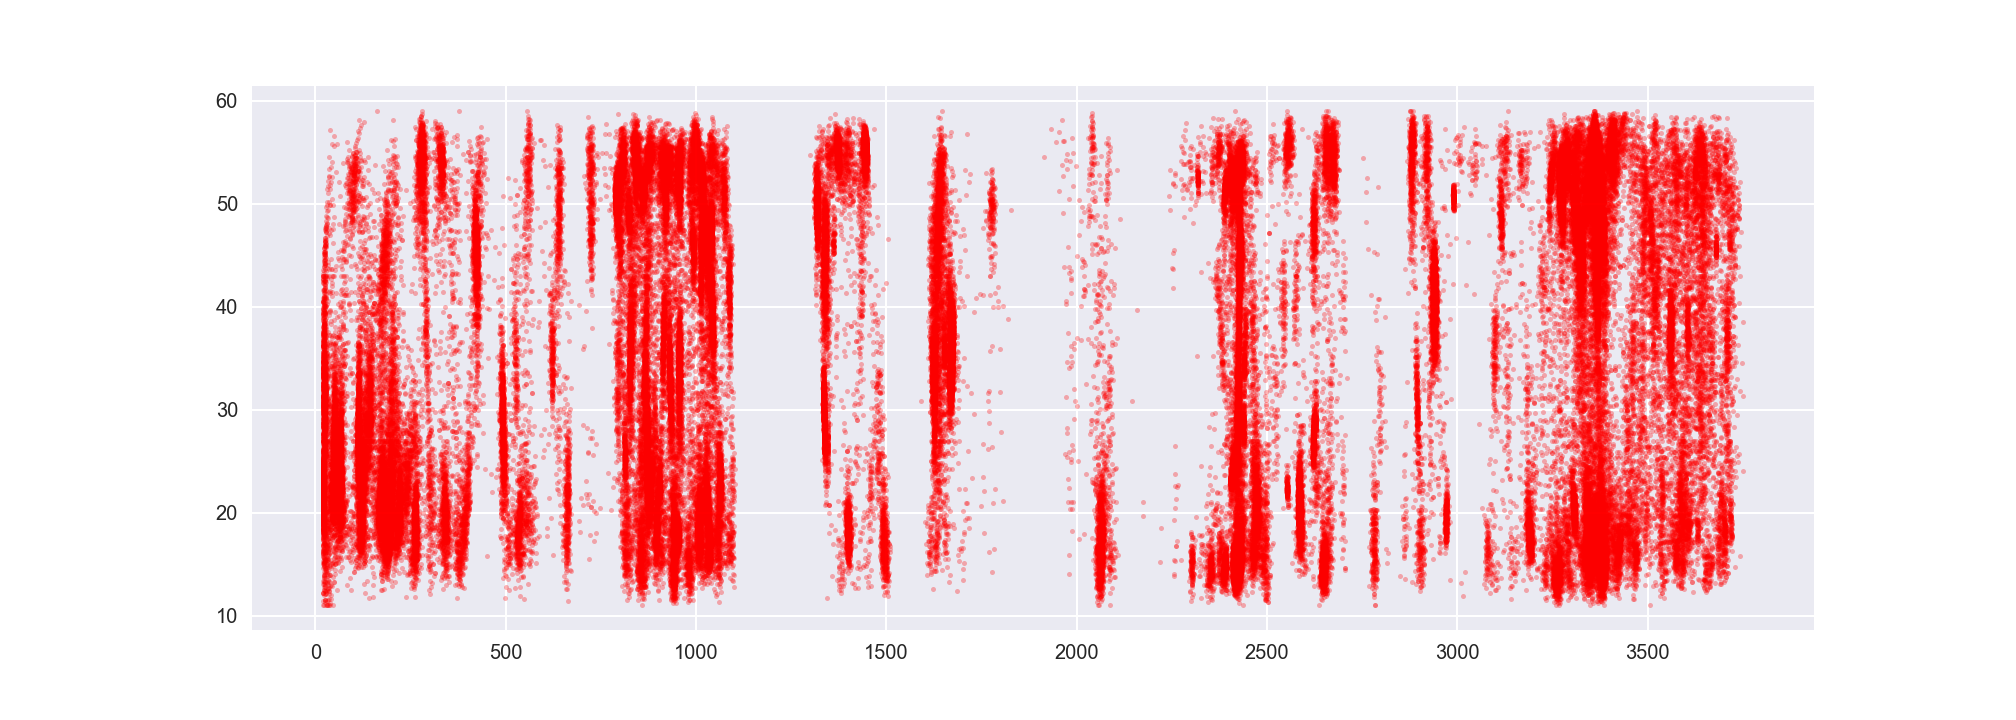

In [4]:
%matplotlib notebook
plt.figure(figsize=(14,5))
plt.plot(ls[:,0], ls[:,1],'r.',ms=5, alpha=0.3)

<IPython.core.display.Javascript object>


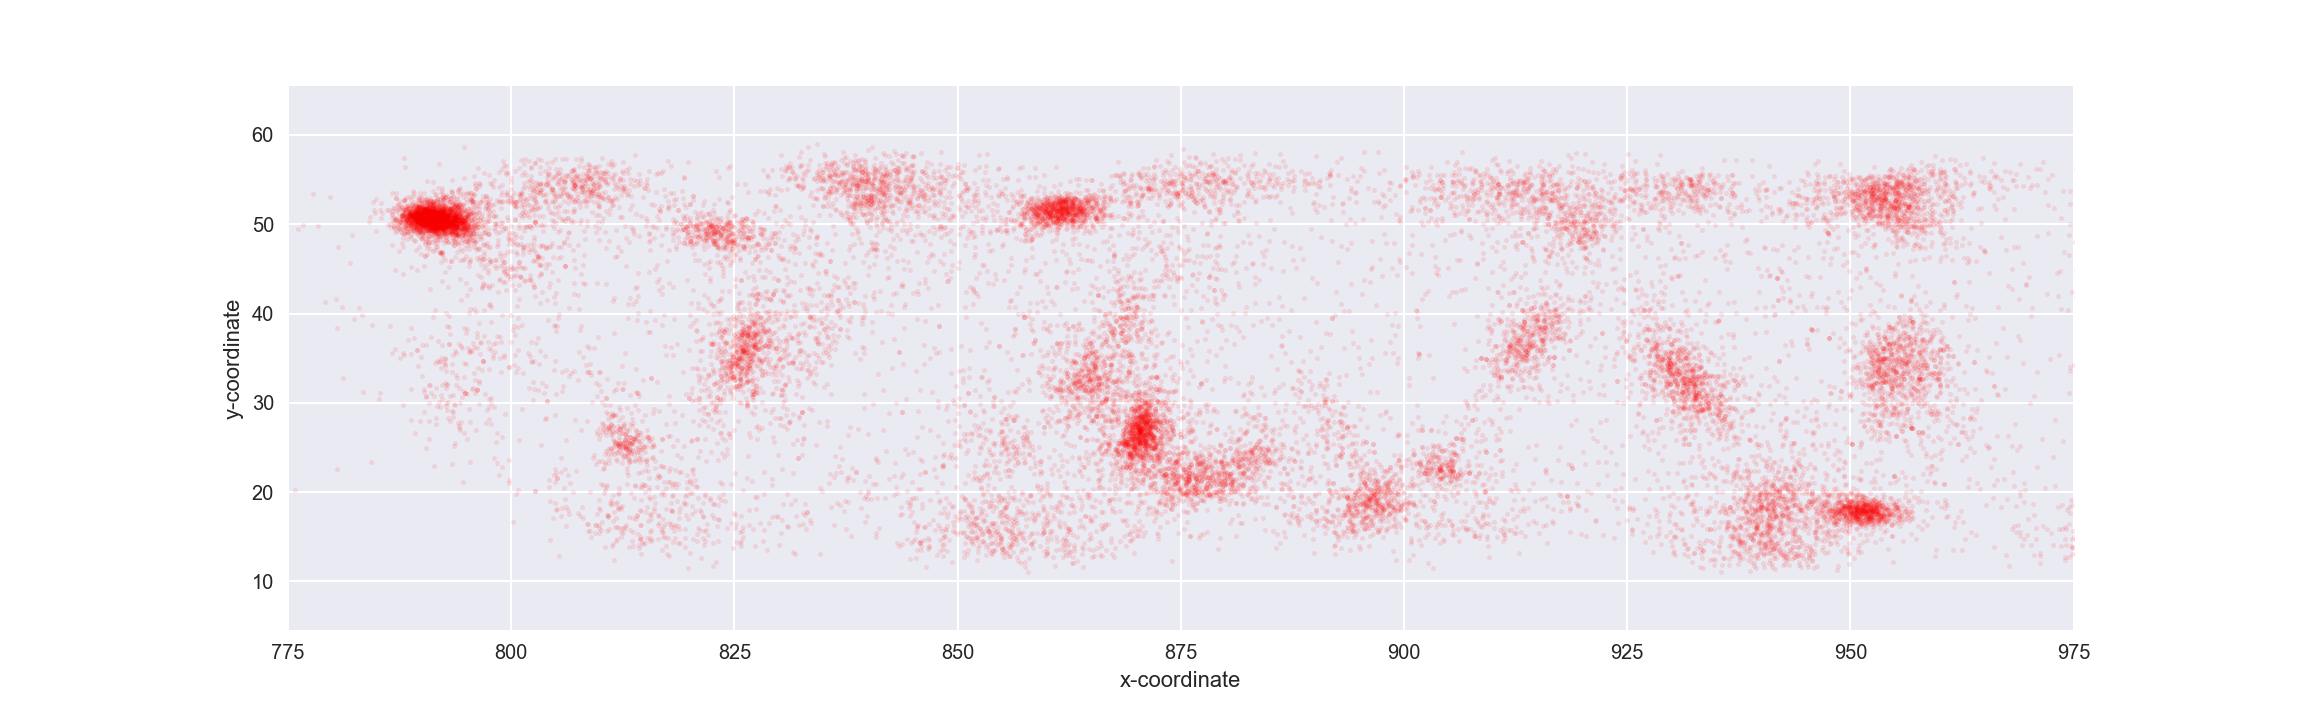

In [79]:
%matplotlib notebook
plt.figure(figsize=(16,5))
plt.plot(ls[:,0], ls[:,1],'r.',ms=5, alpha=0.1)
plt.axis('equal')
plt.xlim((775,975))
plt.ylim((10,60))
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')

<IPython.core.display.Javascript object>


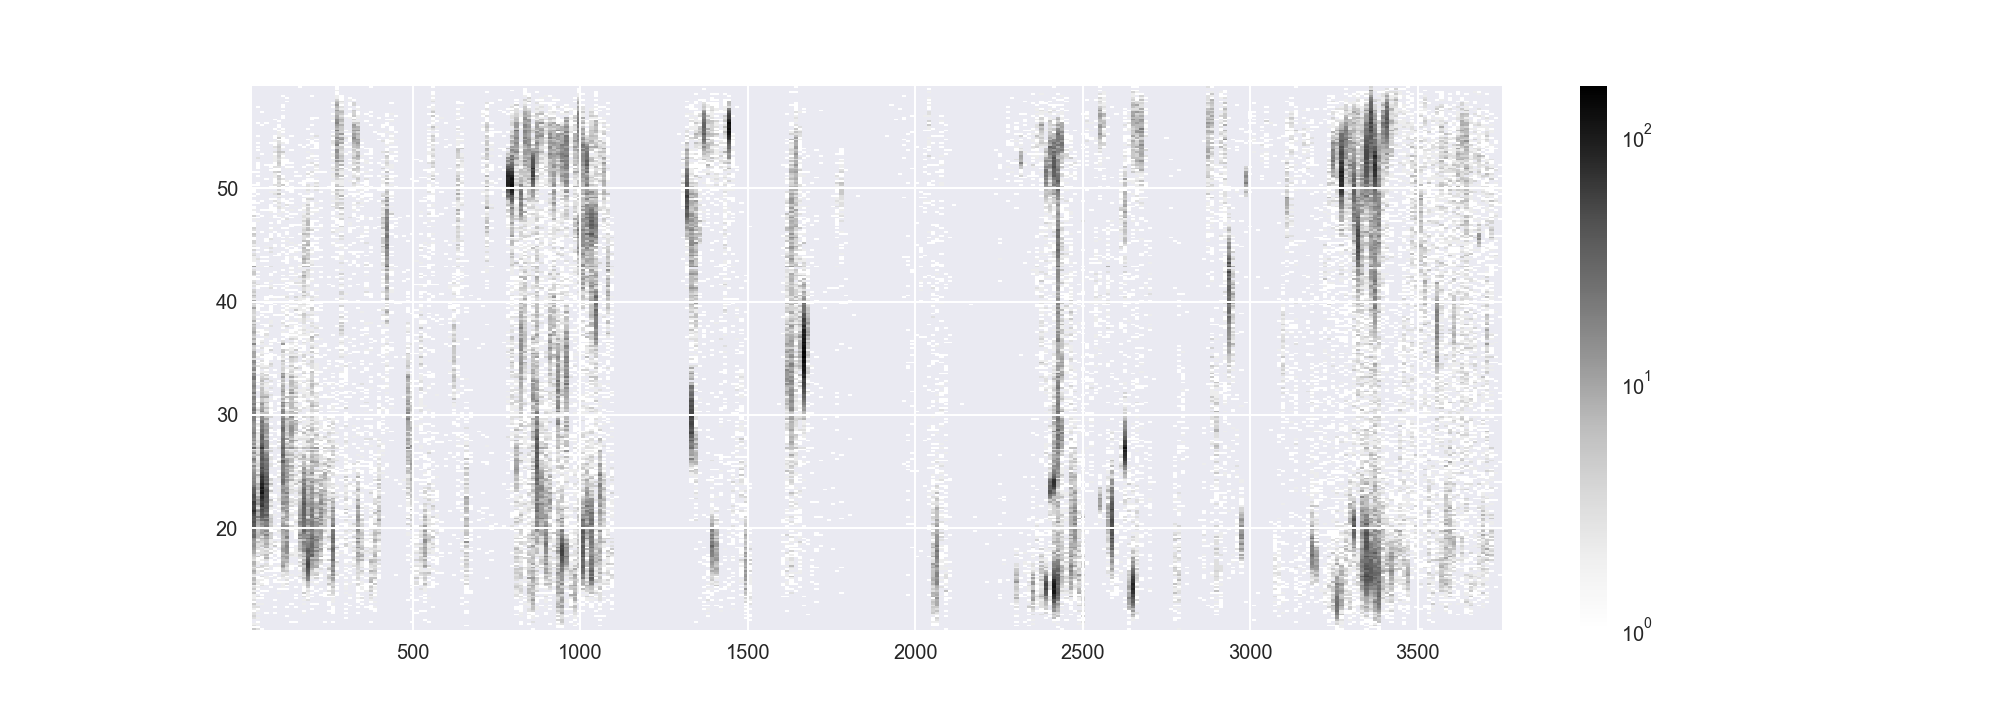

In [6]:
%matplotlib notebook
plt.figure(figsize=(14,5))
plt.hist2d(ls[:,0], ls[:,1], bins=300, norm=LogNorm())
plt.colorbar()

In [8]:
n = len(ls)
n

148756

In [9]:
ms = MeanShift(bandwidth = 8, bin_seeding=True, min_bin_freq=10, n_jobs=-1)
ms.fit(ls)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
# print(cluster_centers)
n_clusters_ = len(np.unique(labels))
print("Number of estimated clusters:", n_clusters_)

('Number of estimated clusters:', 206)


<IPython.core.display.Javascript object>


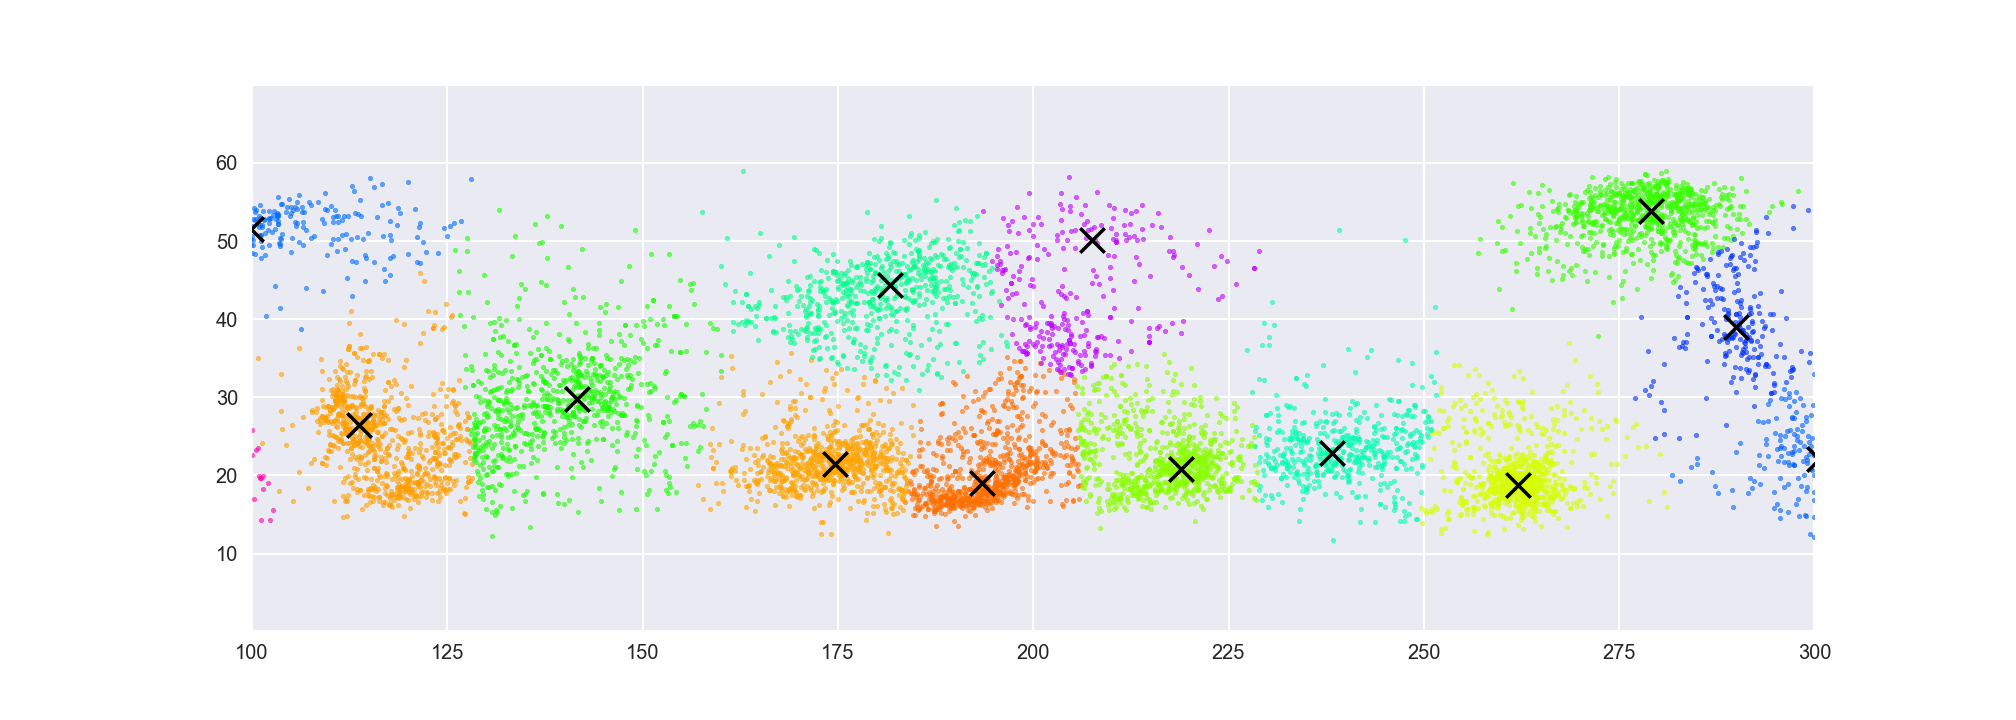

(100, 300)

In [10]:
plt.figure(figsize=(14,5))
# colors = 100*['r', 'g', 'b', 'c', 'k', 'y', 'm']
colors = plt.cm.hsv(1.*np.arange(n_clusters_)/n_clusters_)

for cl in np.unique(labels):
    inds = np.where(labels==cl)[0][:800]
    plt.scatter(ls[inds,0], ls[inds,1], marker='.', color = colors[cl],s=20, alpha=0.6)

plt.scatter(cluster_centers[:,0], cluster_centers[:,1], marker="x", color ='k', s=150, linewidths = 5, zorder=10)
plt.axis('equal')
plt.xlim((100,300))


In [24]:
cutouts = np.loadtxt('pca_cutouts', dtype=float, delimiter=' ' )
cutouts.shape, ls.shape

NameError: name 'ls' is not defined

<IPython.core.display.Javascript object>


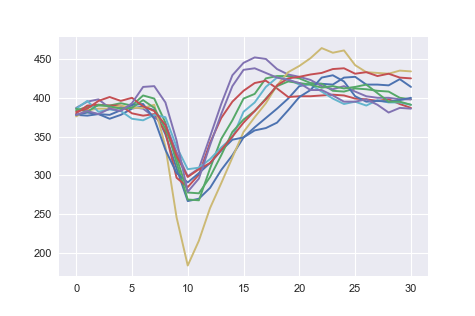

In [44]:
%matplotlib notebook
for i in range(10):
    plt.plot(np.arange(31), cutouts[i])

In [33]:
pca = PCA(n_components=2, whiten=True)
cutouts_pca = pca.fit_transform(cutouts)
cutouts_pca.shape

(148756, 2)

<IPython.core.display.Javascript object>


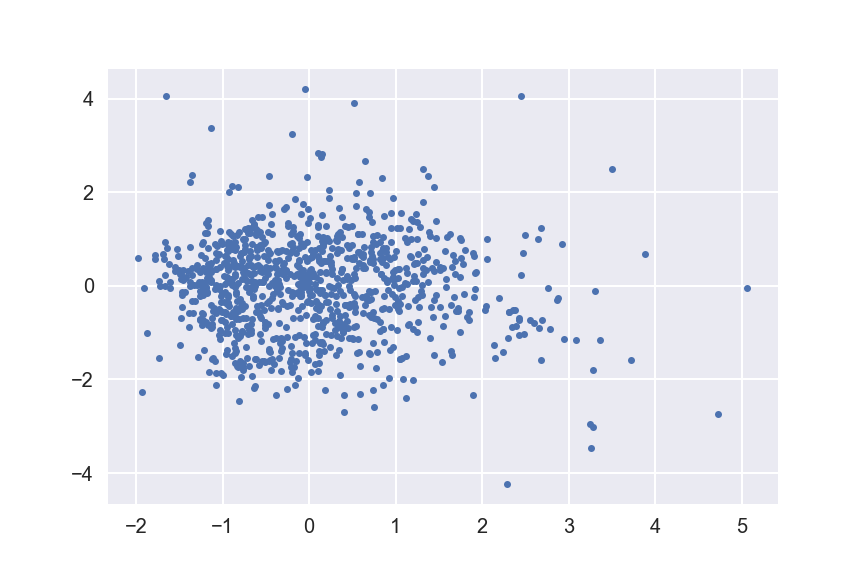

In [53]:
plt.figure()
plt.plot(cutouts_pca[:1000,0], cutouts_pca[:1000,1],'.')

<IPython.core.display.Javascript object>


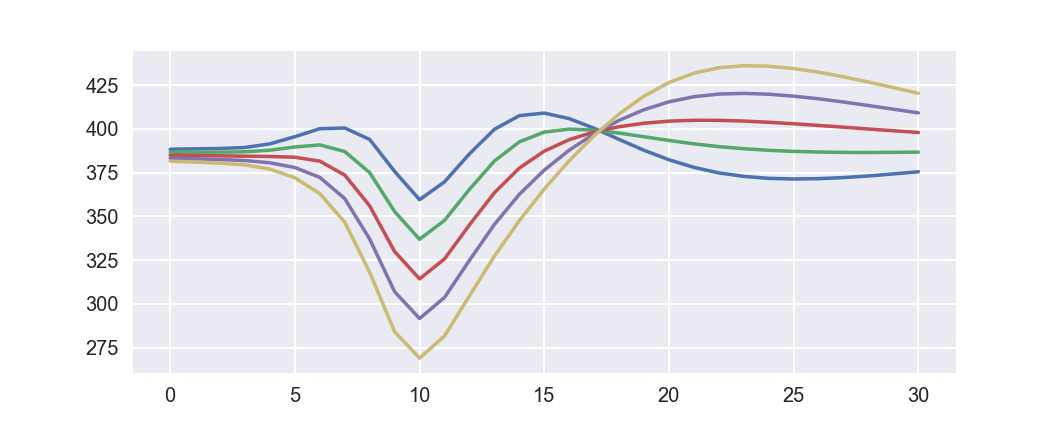

In [56]:
plt.figure()
pc1, pc2 = pca.components_
array = np.vstack((np.arange(-2,3),np.zeros(5))).T
data = pca.inverse_transform(array)
for i in range(5):
    plt.plot(np.arange(len(data[i])),data[i])

<IPython.core.display.Javascript object>


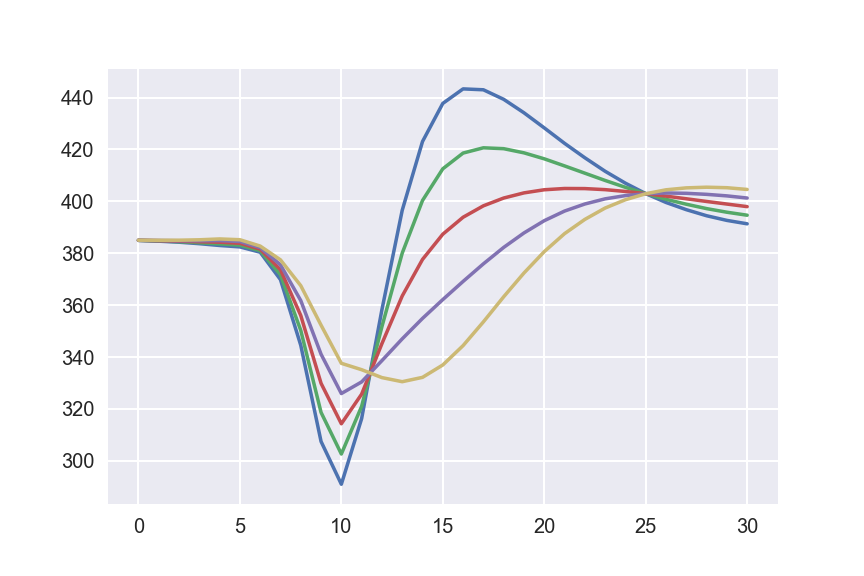

In [75]:
plt.figure()
array = np.vstack((np.zeros(5),np.arange(-2,3))).T
data = pca.inverse_transform(array)
for i in range(5):
    plt.plot(np.arange(len(data[i])),data[i])

<IPython.core.display.Javascript object>


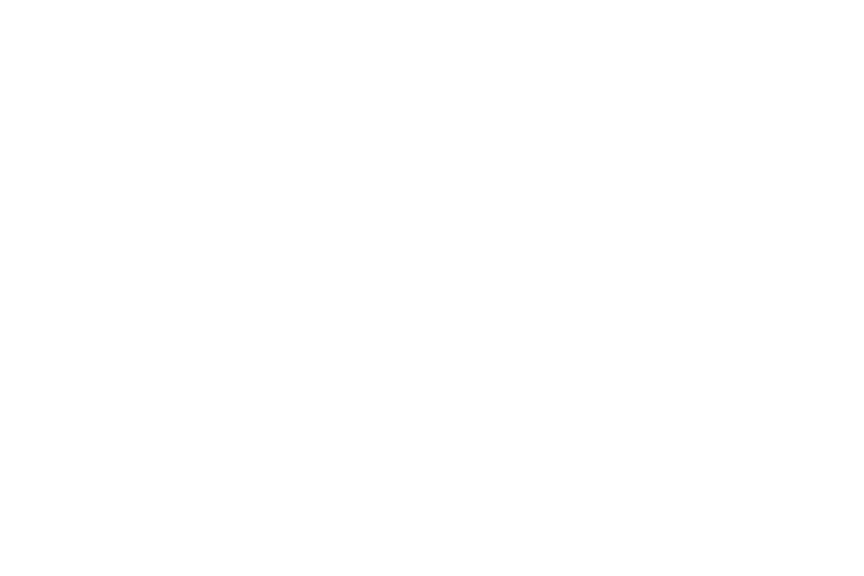

<IPython.core.display.Javascript object>


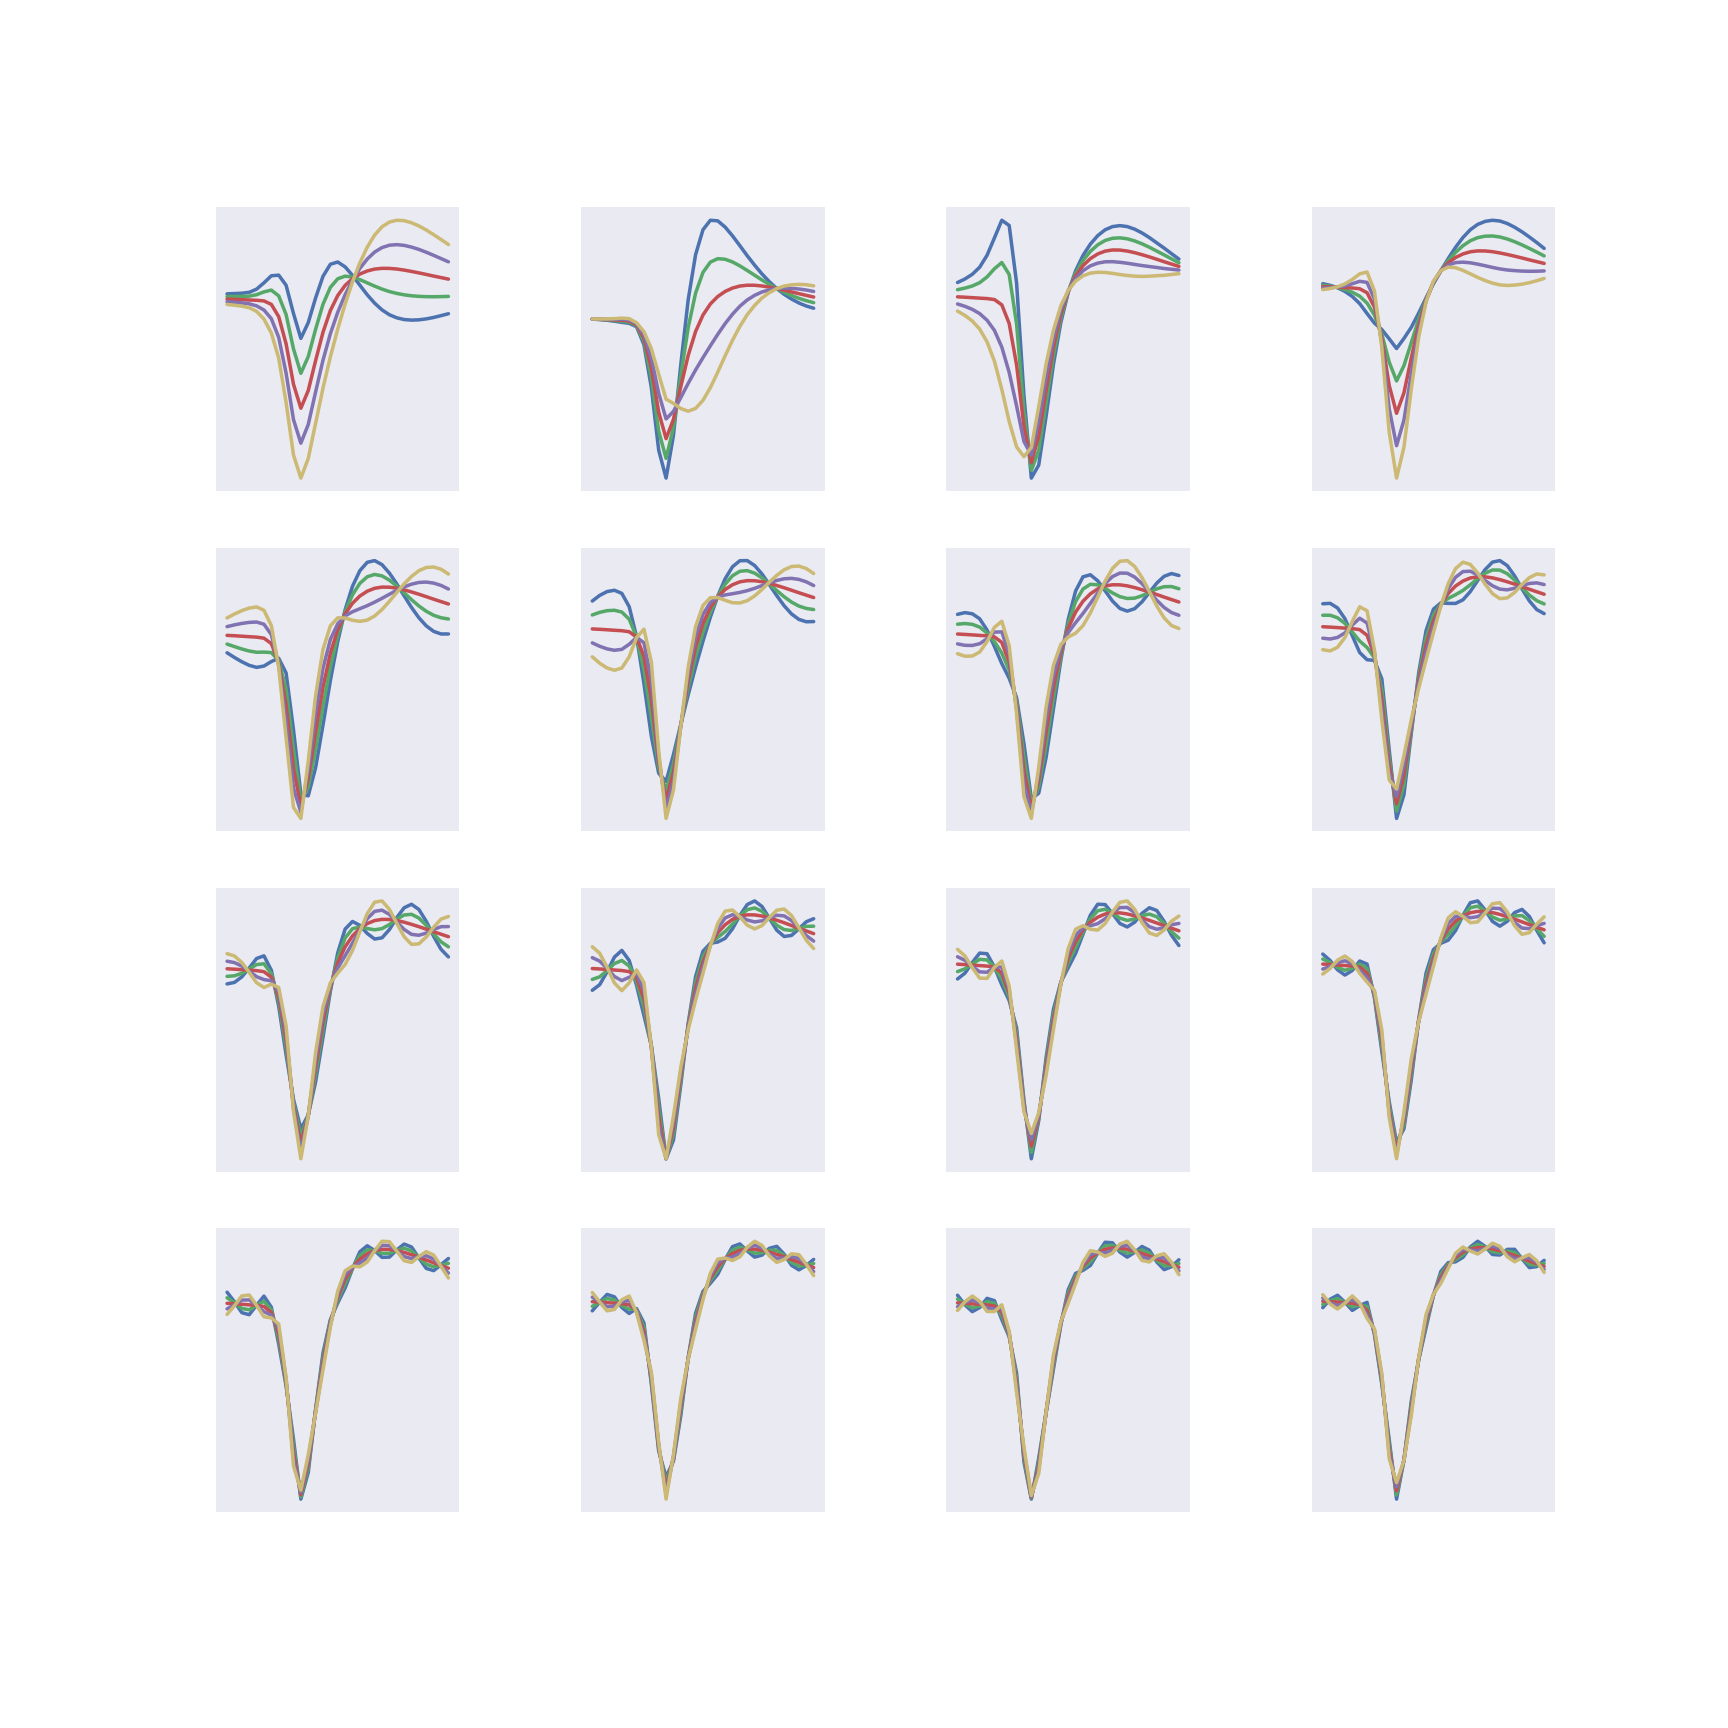

In [64]:
plt.figure()
pca1 = PCA(n_components=16, whiten=True)
pca1.fit(cutouts)
array = np.zeros((5,16))
plt.figure(figsize=(12,12))
for cl in range(16):
    plt.subplot(4,4,cl+1)
    array = np.zeros((5,16))
    array[:,cl] = np.arange(-2,3)
    data = pca1.inverse_transform(array)
    for i in range(5):
        plt.plot(np.arange(len(data[i])),data[i])
    plt.xticks(())
    plt.yticks(())

In [ ]:
ms = MeanShift(bandwidth = 8, bin_seeding=True, min_bin_freq=10, n_jobs=-1)
ms.fit(20*cutouts_pca)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
# print(cluster_centers)
n_clusters_ = len(np.unique(labels))
print("Number of estimated clusters:", n_clusters_)

In [ ]:
plt.figure(figsize=(14,5))
# colors = 100*['r', 'g', 'b', 'c', 'k', 'y', 'm']
colors = plt.cm.hsv(1.*np.arange(n_clusters_)/n_clusters_)

for cl in np.unique(labels):
    inds = np.where(labels==cl)[0][:800]
    plt.scatter(ls[inds,0], ls[inds,1], marker='.', color = colors[cl],s=20, alpha=0.6)

plt.scatter(cluster_centers[:,0], cluster_centers[:,1], marker="x", color ='k', s=150, linewidths = 5, zorder=10)
plt.axis('equal')
plt.xlim((100,300))

In [65]:
fourvec = np.hstack((ls, 20*cutouts_pca))

In [66]:
fourvec.shape

(148756, 4)

In [67]:
ms = MeanShift(bandwidth = 8, bin_seeding=True, min_bin_freq=10, n_jobs=-1)
ms.fit(fourvec)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
# print(cluster_centers)
n_clusters_ = len(np.unique(labels))
print("Number of estimated clusters:", n_clusters_)

('Number of estimated clusters:', 256)


<IPython.core.display.Javascript object>


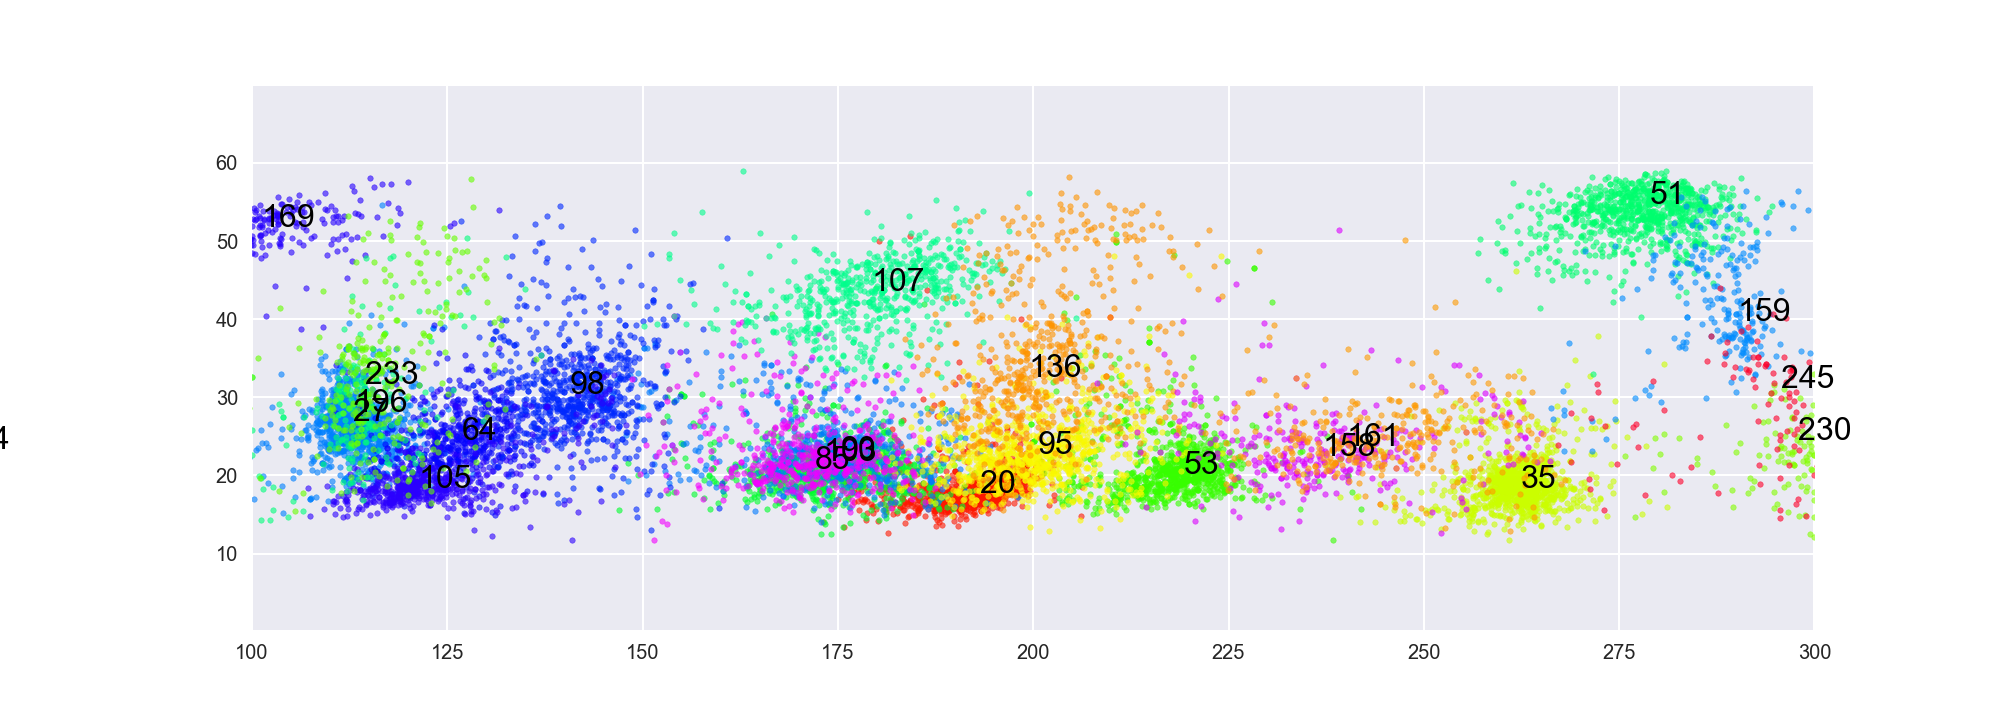

(100, 300)

In [13]:
%matplotlib notebook
plt.figure(figsize=(14,5))
# colors = 100*['r', 'g', 'b', 'c', 'k', 'y', 'm']
colors = plt.cm.hsv(1.*np.random.permutation(n_clusters_)/n_clusters_)

for cl in np.unique(labels):
    inds = np.where(labels==cl)[0][:1000]
    plt.scatter(ls[inds,0], ls[inds,1], marker='.', color = colors[cl],s=30, alpha=0.6)
    plt.text(cluster_centers[cl,0], cluster_centers[cl,1], str(cl), color='k', fontsize=16)

# plt.scatter(cluster_centers[:,0], cluster_centers[:,1], marker="x", color ='k', s=150, linewidths = 5, zorder=10)
plt.axis('equal')
plt.xlim((100,300))

<IPython.core.display.Javascript object>


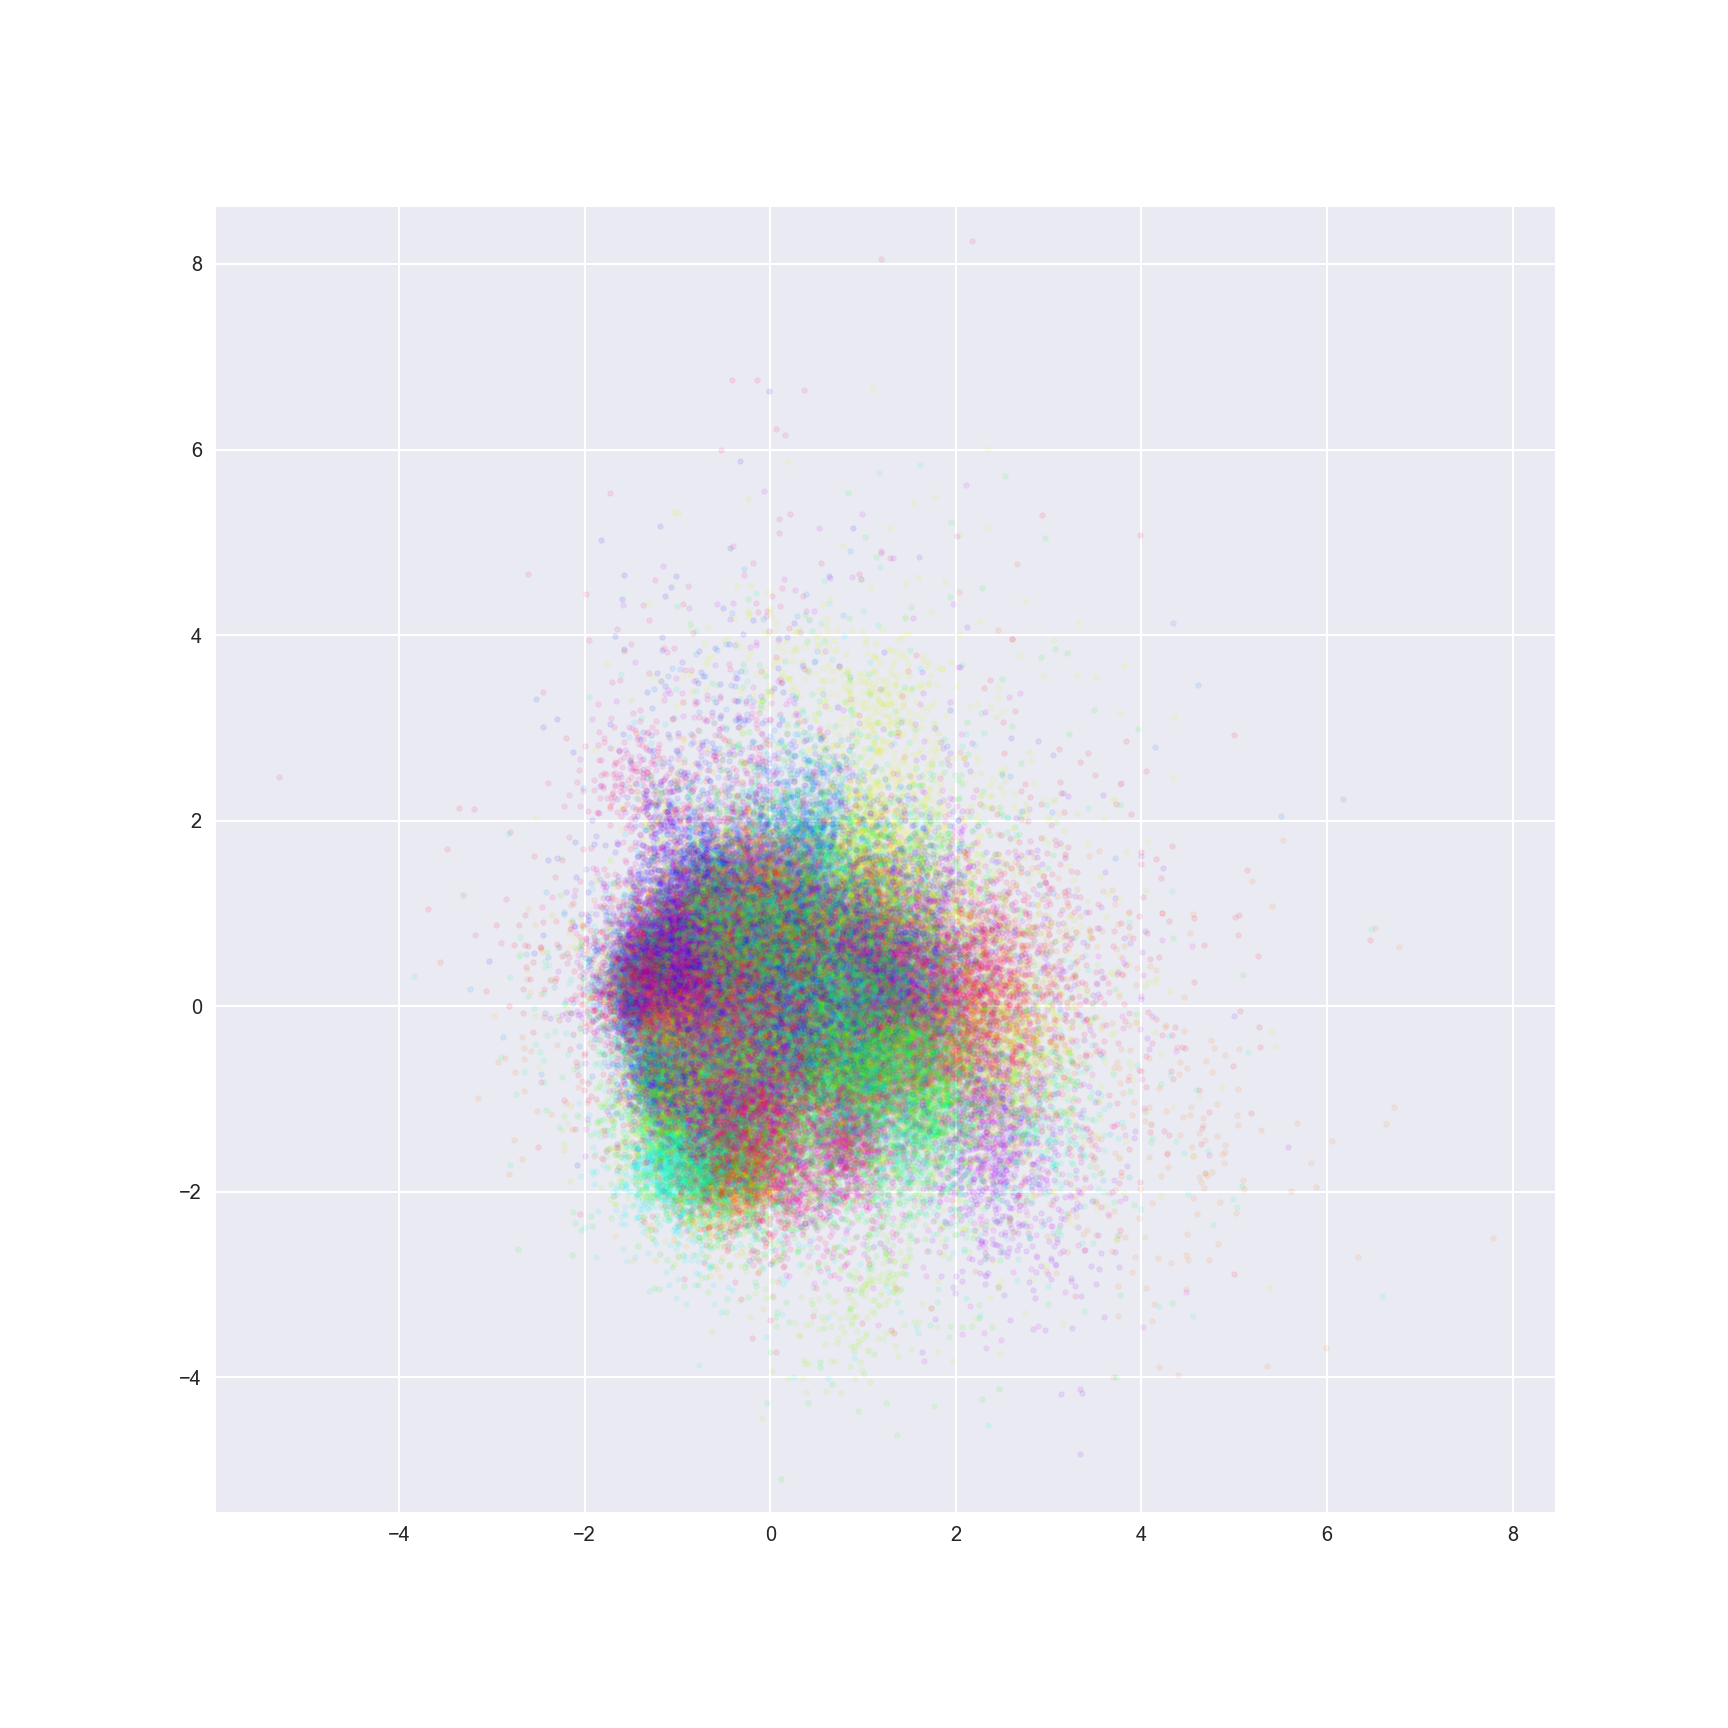

(-5.9730783765099815,
 8.4595811218206247,
 -5.7839805031923914,
 8.9434507448162783)

In [74]:
%matplotlib notebook
plt.figure(figsize=(12,12))
# colors = 100*['r', 'g', 'b', 'c', 'k', 'y', 'm']
colors = plt.cm.hsv(1.*np.random.permutation(n_clusters_)/n_clusters_)

for cl in np.unique(labels):
    inds = np.where(labels==cl)[0][:1000]
    plt.scatter(cutouts_pca[inds,0], cutouts_pca[inds,1], marker='.', color = colors[cl],s=30, alpha=0.1)

# plt.scatter(cluster_centers[:,0], cluster_centers[:,1], marker="x", color ='k', s=150, linewidths = 5, zorder=10)
plt.axis('equal')

<IPython.core.display.Javascript object>


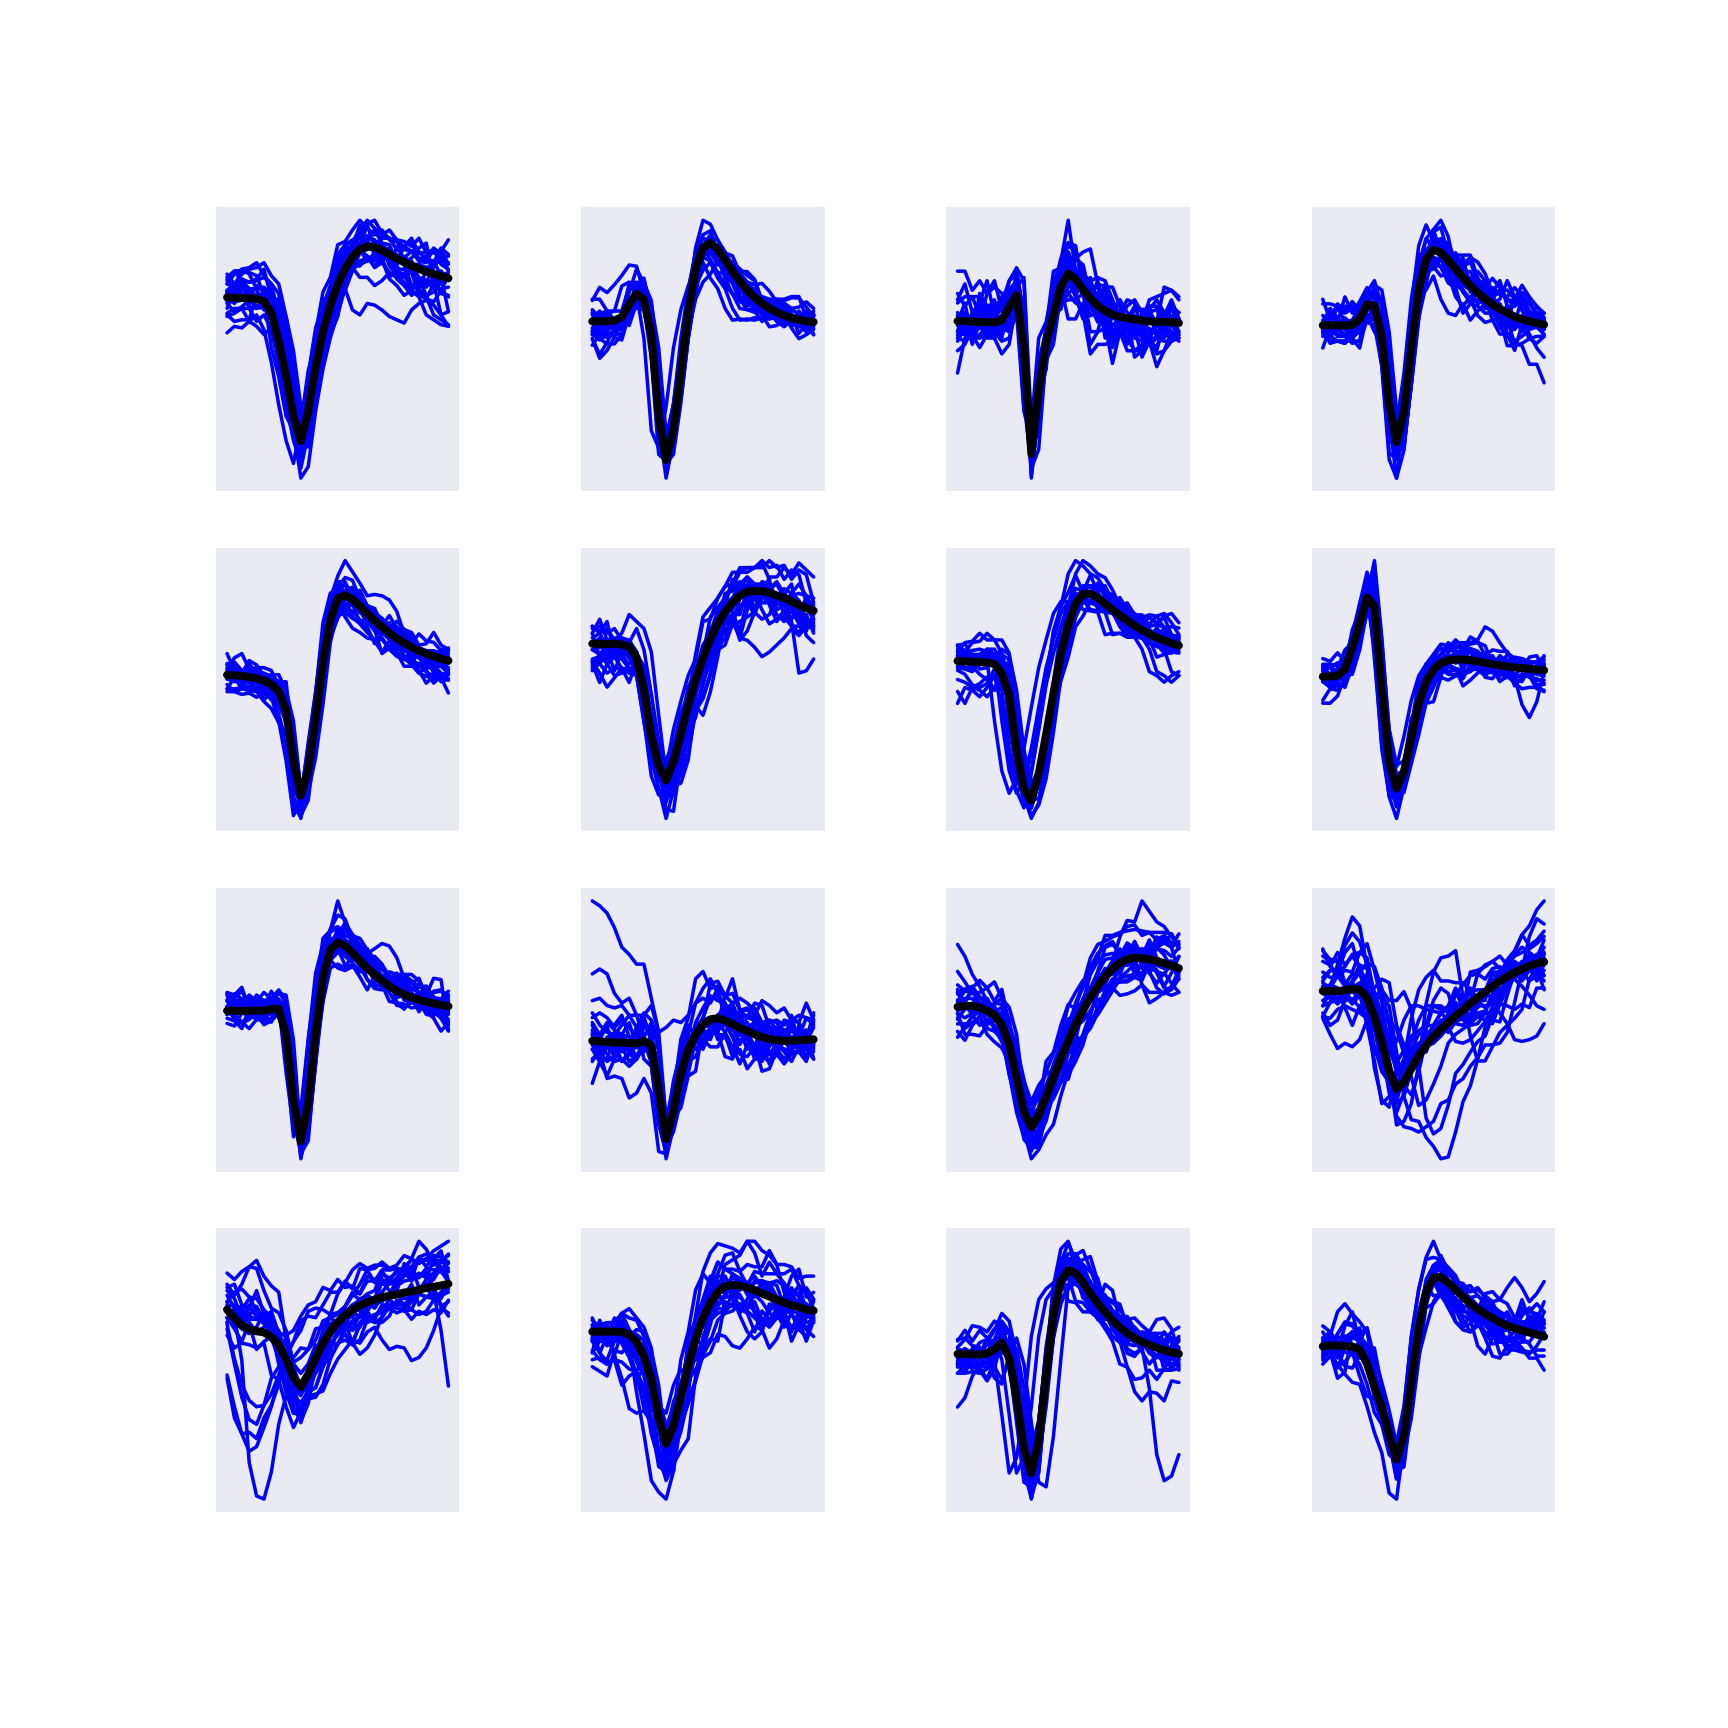

In [14]:
plt.figure(figsize=(12,12))
for cl in range(16):
    plt.subplot(4,4,cl+1)
    inds = np.where(labels==cl)[0]
    plt.plot(cutouts[inds[:20],:].T,'b');
    plt.plot(np.mean(cutouts[inds,:],axis=0),'k', lw=4);
    plt.xticks(())
    plt.yticks(())

<IPython.core.display.Javascript object>


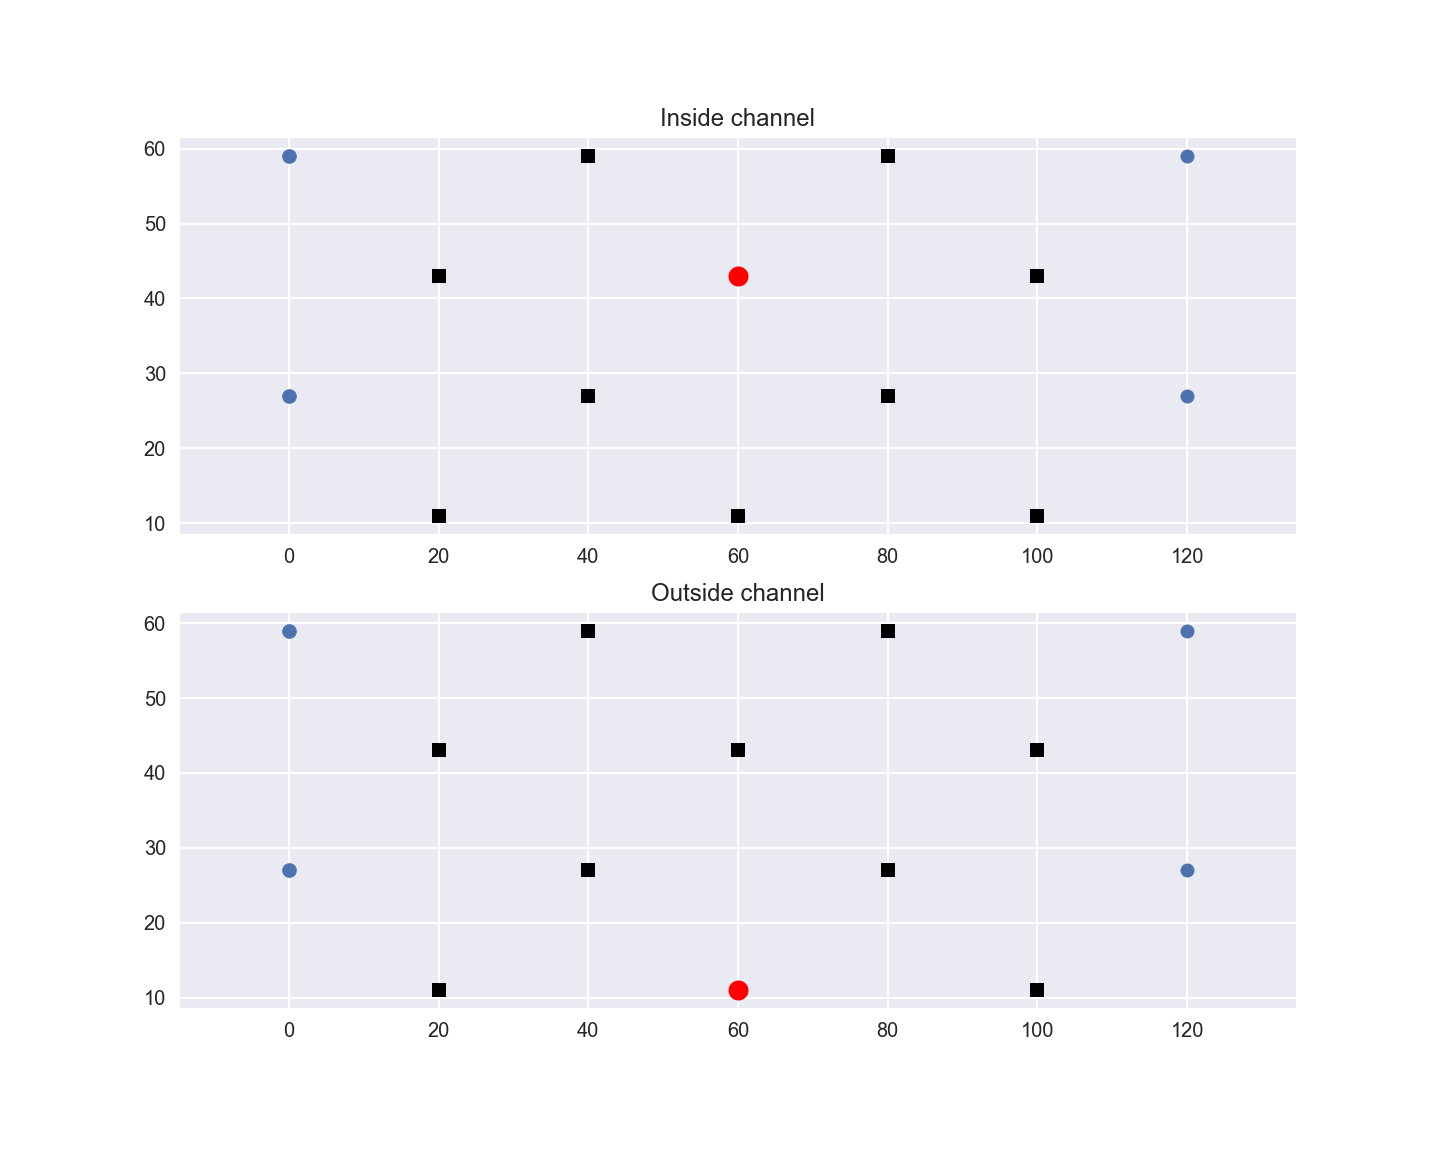

In [27]:
chpos = np.load('/Users/josh/Project/data/chpos.npy')[:20]
%matplotlib notebook
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title('Inside channel')
plt.axis('equal')
plt.scatter(chpos[2:4,1]-40, chpos[2:4,0])
plt.plot(chpos[4:8,1]-40, chpos[4:8,0], 'ks')
plt.plot(chpos[8,1]-40, chpos[8,0], 'ro', ms=10)
plt.plot(chpos[9:14,1]-40, chpos[9:14,0], 'ks')
plt.plot(chpos[14:16,1]-40, chpos[14:16,0], 'C0o')
# plt.xticks(())
# plt.yticks(())

plt.subplot(2,1,2)
plt.axis('equal')
plt.title('Outside channel')
plt.scatter(chpos[2:4,1]-40, chpos[2:4,0])
plt.plot(chpos[4:9,1]-40, chpos[4:9,0], 'ks')
plt.plot(chpos[9,1]-40, chpos[9,0], 'ro', ms=10)
plt.plot(chpos[10:14,1]-40, chpos[10:14,0], 'ks')
plt.plot(chpos[14:16,1]-40, chpos[14:16,0], 'C0o')
# plt.xticks(())
# plt.yticks(())

<IPython.core.display.Javascript object>


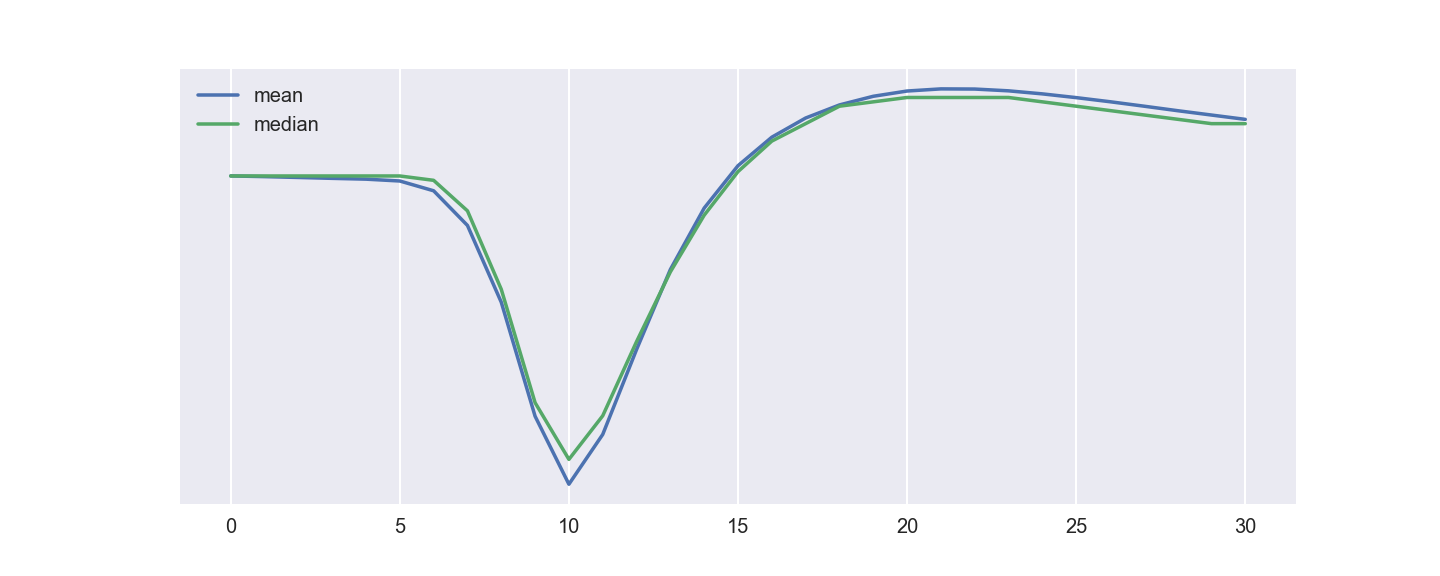

([], <a list of 0 Text yticklabel objects>)

In [36]:
%matplotlib notebook
plt.figure(figsize=(10,4))
mean = np.mean(cutouts, axis=0)
median = np.median(cutouts,axis=0)
plt.plot(np.arange(31),mean, label = 'mean')
plt.plot(np.arange(31),median, label = 'median')
plt.legend()
plt.yticks(())